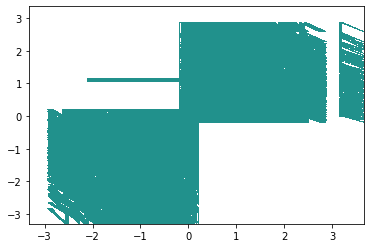

In [2]:
# test settings:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt

# RNG = np.random.default_rng(seed = 0)
x1 = np.random.normal(0,1,1000)
x2 = np.random.normal(0,1,1000)
X1, X2 = np.meshgrid(x1, x2)

y = expit(X1 * X2) >= 0.5 #np.sin(1*X)*np.sin(1*Y)>= 0.5
plt.contourf(X1, X2, y, levels=[0,.9]) # polka dot z-values here are 0s and 1s

In [3]:
from functionTree import rpTree, kdTree, classifcationTree, honestTree
from baseline_models import forward_selection, lasso_base_model
from variable_selection import variable_sel, Pool, evaluation_result
import os
import pandas as pd
def data_generator(n=1000, irr=98):
    x1 = np.random.normal(0,1,n)
    x2 = np.random.normal(0,1,n)
    targets = expit(x1 * x2) >= 0.5
    irr_lst = [np.random.normal(0, 1, n) for _ in range(irr)]
    for each in [x1, x2]:
        irr_lst.append(each)
    irr_columns = ['X' + str(i) for i in range(3, irr+3)]
    rr_columns = ['X1', 'X2']
    cols = irr_columns + rr_columns
    predictors = pd.DataFrame(np.column_stack(irr_lst))
    predictors.columns = cols
    return predictors, targets

PROJECT_ROOT_DIR = "."
OUTPUTPATH = os.path.join(PROJECT_ROOT_DIR, "output/test1")

In [4]:
import pandas as pd
import timeit
import warnings
from copy import deepcopy
warnings.filterwarnings("ignore")
# from DataGenerator import *
variable_lst = []
aic_list = []
accuracy_list = []
recall_list = []
precision_list = []
f1_list = []
types_list = []
pool = Pool()
rep = 1
model_dic = {'rp': rpTree(Rep=rep),
        'kd': kdTree(Rep=rep),
        'classification': classifcationTree(Rep=rep),
        'honest': honestTree(Rep=rep),
        'linear': forward_selection,
        'lasso': lasso_base_model}

for size in [20, 50, 100, 500, 1000, 2000, 4000, 8000]: # may add more sample sizes
    start = timeit.default_timer()
    for _ in range(1):
        predictors, target = data_generator(size, 48)  # for train, only relevant
        
        total_columns = list(predictors.columns)
        pos_columns = ['X1', 'X2']
        neg_columns = [each for each in total_columns if each not in pos_columns]

        for model_name in model_dic:
            model = deepcopy(model_dic[model_name])
            if model_name == 'linear':
                best_subset, best_aic = model(predictors, target)
            elif model_name == 'lasso':
                best_subset = model(predictors, target)
            else:
                best_subset, best_aic = variable_sel(predictors, target, pool, model, best_subset=[])
            accuracy, recall, precision, f1 = evaluation_result(best_subset, pos_columns, neg_columns)
            variable_lst.append(best_subset)
            aic_list.append(best_aic)
            accuracy_list.append(accuracy)
            recall_list.append(recall)
            precision_list.append(precision)
            f1_list.append(f1)
            types_list.append(model_name)
        
    file_name = str(size) + '.csv'
    dic_current = {'aic': aic_list, 'Acc': accuracy_list, 'Recall': recall_list, 
                    'precision': precision_list, 'f1': f1_list, 'variables': variable_lst, 'types': types_list}
    df = pd.DataFrame(dic_current)
    df.to_csv(os.path.join(OUTPUTPATH, file_name), index=False)
    end = timeit.default_timer()
    print(size)
    print(end-start)
pool.close()

20
6.625624372000001
50
14.199119453000002
100
27.845832817
500
196.64339326599998
